# Vehicle Detection and Tracking Project

- Perform a Histogram of Oriented Gradient (HOG) feature extraction on a labeled training set of images and train a classifier (SVM or Decision Trees)
- Apply a color transform and append binned color features to the HOG feature vector
- Experiment training your classifier on HOG / color features only, and then on the combination of the two 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for taining and testing.
- Using a Decision Tree classifier, explore the feature importances and consider pruning or adding new features.
- Implement a sliding-window technique and use your trained classifier to search for vechiles in images.
- Estimate a bounding box for vehicles detected.
- Run your pipeline on a video stream and implement tracking to follow detected vehicles.
- Estimate distance and trajectory of detected vehicles.

# Imports

In [1]:
import os
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn import svm
from skimage import color, exposure
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from AdvLaneLine import *

%matplotlib inline
# sklearn.preprocessing.StandardScaler()

# Images

In [2]:
imagesExtra     = glob.glob('non-vehicles/Extras/extra*.png')
imagesGTI       = glob.glob('non-vehicles/GTI/image*.png')
imagesGTIFar    = glob.glob('vehicles/GTI_Far/image*.png')
imagesGTILeft   = glob.glob('vehicles/GTI_Left/image*.png')
imagesGTIMiddle = glob.glob('non-vehicles/GTI_MiddleClose/image*.png')
imagesGTIRight  = glob.glob('vehicles/GTI_Right/image*.png')
imagesGTIKITTI  = glob.glob('vehicles/KITTI_extracted/*.png')

# How Many images in the dataset.

In [3]:
# images are divided up into vehicles and non-vehicles folders 
# (each of which contains subfolder) First locate vechile images
basedir = 'vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti, generated by me
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
# Do the same thing for non-vehicle images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


# Hog Features, Bin Spatial and Color histogram

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    #features = cv2,resize(img, size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32): # bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) #, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) #, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) #, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Calling Color Histogram and Bin Spatial to Find Extract Features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, 
                     hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                         pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, 
                                                feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Sliding Window Function to find the cars

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],  xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Drawing the boundaries of the boxes

In [9]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Single Image Extraction

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, 
                                                     pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, 
                                                           cell_per_block, vis=True, 
                                                           feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, 
                                                feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Window Searching for images

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), 
                   hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, 
                   cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, 
                   hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                       hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [12]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i], fontsize = 25)
        else:
            plt.imshow(img)
            plt.title(titles[i], fontsize = 25)

In [13]:
# Chooserandom car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat , 
                                                  hog_feat=hog_feat, vis=vis)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                                                        spatial_size=spatial_size, 
                                                        hist_bins=hist_bins, orient=orient, 
                                                        pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, 
                                                        hog_channel=hog_channel, 
                                                        spatial_feat=spatial_feat, 
                                                        hist_feat=hist_feat, 
                                                        hog_feat=hog_feat, vis=True)

# Showing the Data Produced

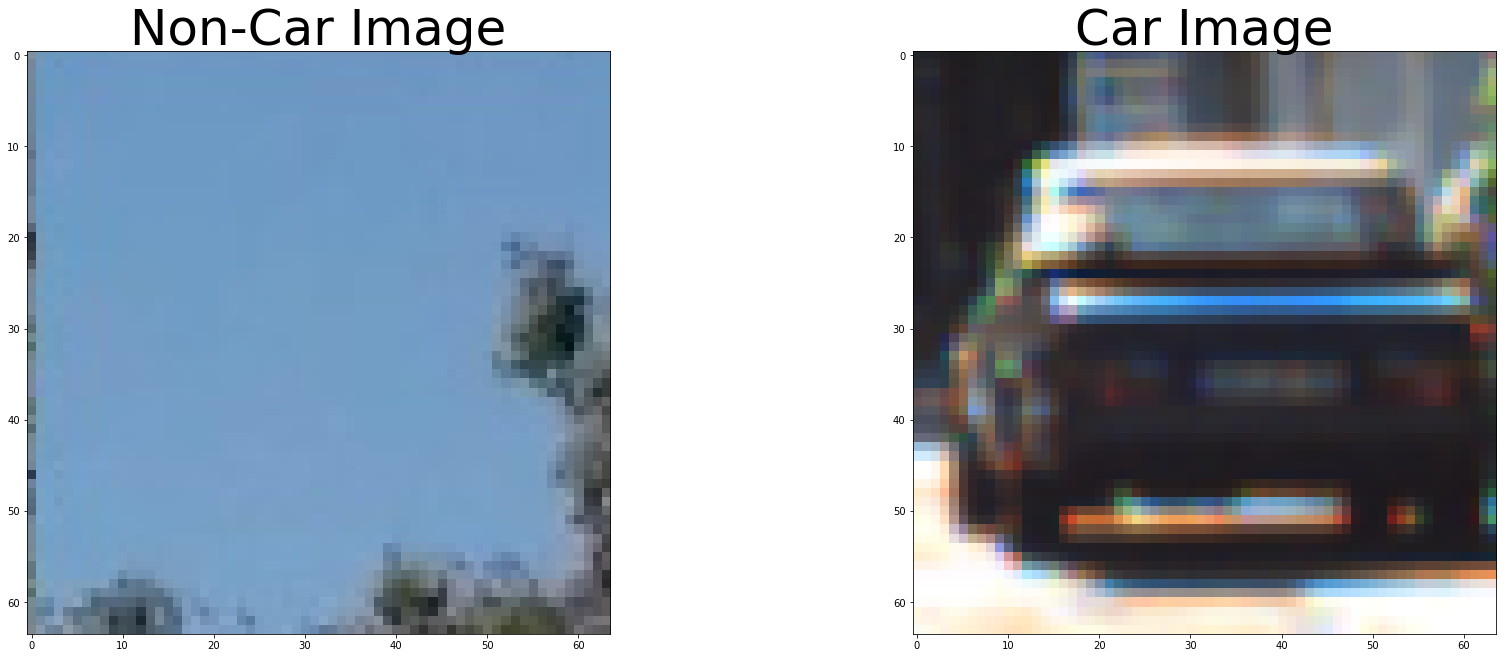

In [14]:
img1 = mpimg.imread('non-vehicles/Extras/extra1.png')
img2 = mpimg.imread('vehicles/KITTI_extracted/1.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Non-Car Image', fontsize=50)
ax2.imshow(img2, cmap='gray')
ax2.set_title('Car Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

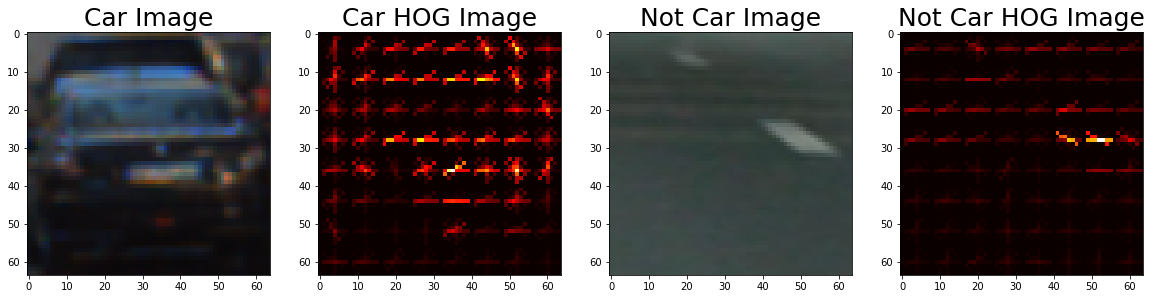

In [15]:
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['Car Image', 'Car HOG Image', 'Not Car Image', 'Not Car HOG Image']
fig = plt.figure(figsize=(20, 6))
visualize(fig, 1, 4, images, titles)

### Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

How I got the HOG features from the get_hog_features function that grabs the key aspects of the image and sets it apart from what the actuall image is. Separating the car and non car images shown above. 

I then used the single_img_feature function to retrieve the HOG image of the car or non-car image which is also shown above. Grabbing random images displaying different features. As you can see the image showns different aspects of the car where the not car image has less to show.

The parameters I selected are also are shown above, these parameters worked best in the images given to me.

In [16]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True # HOG features on or off

out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
scale = 1.5
out_images = []
out_maps = []
images = []
titles = []
y_start_stop = [400, 656] # Min and Max in y to search in slide_window()
overlap = 0.5

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars # np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

print(time.time()-1, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scalar
X_scaler = StandardScaler().fit(X)
# Apply the scalar to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.1, random_state=rand_state)

print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell,', cell_per_block,
     'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC =', round(svc.score(X_test, y_test), 4))

1493595885.582647 Seconds to compute features...
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
24.72 Seconds to train SVC...
Test Accuracy of SVC = 0.9899


## Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The features are shown above in the code, I used a Linear Support Vector Classification to solve issues in the video and trained the classifier with a train_test_split to find the best suited data and to avoid overfitting and underfitting.

In [19]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

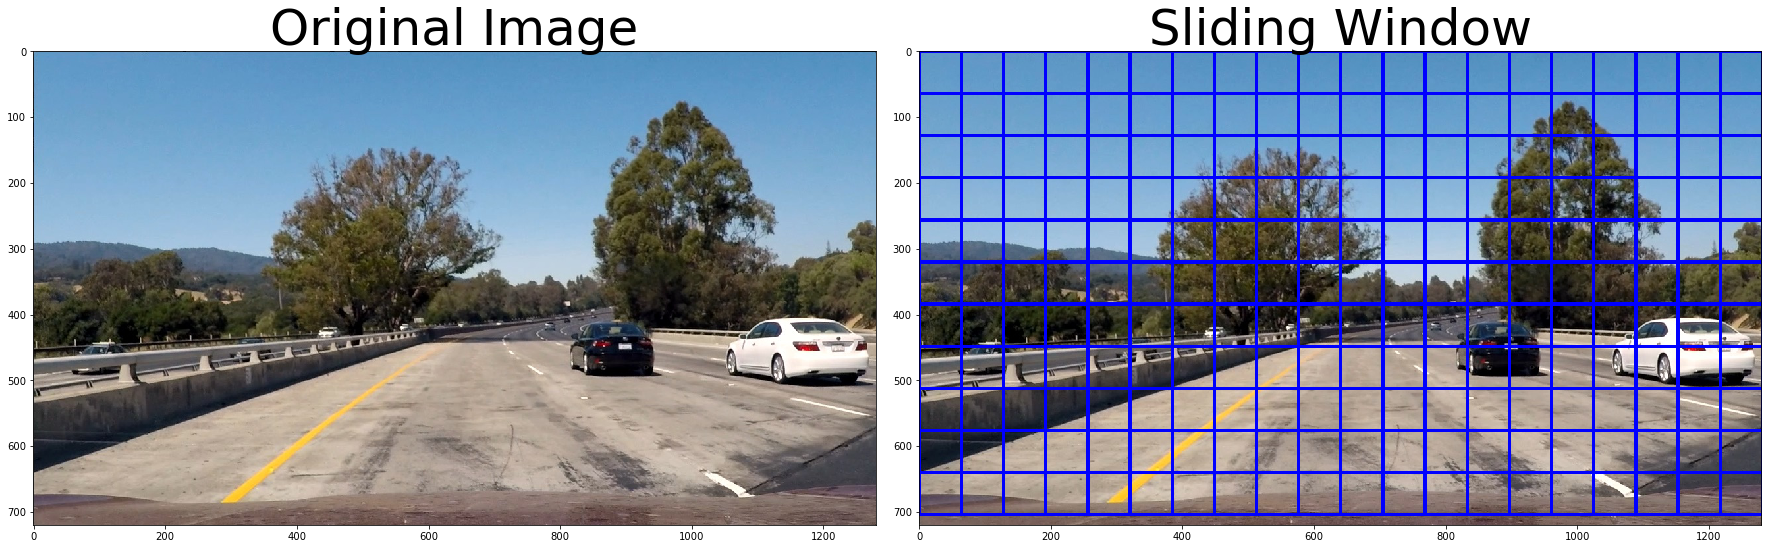

In [20]:
img3 = mpimg.imread('test_images/1.jpg')
windows = slide_window(img3, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(img3, windows, color=(0, 0, 255), thick=4)                    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img3)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(window_img, cmap='gray')
ax2.set_title('Sliding Window', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen.

The sliding window is shown above. This type of imagery caputuring was selected because of the shape of the image and the best way to track the cars and give the best results, which is shown above

# Function to help to find the cars

In [21]:
# Iterate over test images
def find_cars(img, scale):

    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_boxes = []
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap

# Heat Map and Threshold

In [22]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 2
    return heatmap

In [23]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

## Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

Using the heatmap and threshold functions helped to find the images and to get rid of false positives. This helped to improve the model and avoid sudden cars in the away. Also to prevent braking from the car. 

# Process Vehicle Detection Video

In [25]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    find_lanes = newPipeline(draw_img)
    return find_lanes

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_name = "test.mp4"
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [33:11<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 32min 51s, sys: 2min 3s, total: 34min 54s
Wall time: 33min 12s


In [27]:
HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(output_name))

In [28]:
class Vehicle():
    def __init__(self):
        self.detected = False # was the vehicle detected in the last iteration?
        self.n_detections = 0 # Number of times this vehicle has been?
        self.n_nondetections = 0 # Number of consecutive times this car has not been detected
        self.xpixels = None # Pixel x values of last detection
        self.ypixels = None # Pixel y values of last detection
        self.recent_xfitted = [] # x position of the last n fits of the bounding box
        self.bestx = None # average x position of the last n fits of the bounding box
        
        self.recent_yfitted = [] # y position of the last n fits of the bounding box
        self.besty = None # average y position of the last n fits of the bounding box
        
        self.recent_wfitted = [] # width position of the last n fits of the bounding box
        self.bestw = None # average width position of the last n fits of the bounding box
        
        self.recent_hfitted = [] # height position of the last n fits of the bounding box
        self.besth = None # average height position of the last n fits of the bounding box

In [29]:
carslist = []
carslist.append(Vehicle())

### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Problems with the box tracking the car, added better code to help assimilate the issues with the car boxes to track the best option in the cars position. The pipeline could fail from not enough data, it could also not be getting the most recent information to help get rid of bad tracking of the cars. Other issues such as on coming traffic, since the vehicle is on the other side. Heatmap could affect the pipeline as well because of sudden light changes on the road. Sudden conflicts like random objects or hilly roads could also alter the pipeline and lead to sudden braking or accident.  